<a href="https://colab.research.google.com/github/TobiasSunderdiek/predicting-bike-sharing-patterns-with-pytorch/blob/master/predicting_bike_sharing_patterns_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differences of a numpy/pandas-based, hand-written calculation of a neural network vs. a pytorch model

This notebook is based on the udacity deep learning nanodegree project for predicting bike sharing data, which can be found here:

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-bikesharing/Predicting_bike_sharing_data.ipynb

I use the udacity implementation as a starting point for a self-learning project in which I try to build the same model with pytorch.

## Data set

The underlying dataset for both of the models will be the bike-sharing dataset, the original dataset is located here:

https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-bikesharing/Bike-Sharing-Dataset/hour.csv

which originaly came from [1].

[1] Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

### Loading dataset from github

In [0]:
# Fetch a single file using the raw GitHub URL.
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-bikesharing/Bike-Sharing-Dataset/hour.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1129k  100 1129k    0     0  2172k      0 --:--:-- --:--:-- --:--:-- 2172k


In [0]:
import pandas as pd

rides = pd.read_csv("/content/hour.csv")
rides_origin = rides
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Convert data
- hot-encode categorical features *season*, *weathersit*, *mnth*, *hr*, *weekday* and drop origin of this features
- drop fields *instant*, *dteday*, *atemp* and *workingday* as in the udacity project
- additionally drop fields *casual* and *registered*, focus on overall output *cnt*
- shift and scale continuous features *cnt*, *temp*, *hum*, *windspeed* so they have zero mean and standard deviation of 1

In [0]:
for feature in ['season', 'weathersit', 'mnth', 'hr', 'weekday']:
  hot_encoded_features = pd.get_dummies(rides[feature], prefix=feature, drop_first=False)
  rides = pd.concat([rides, hot_encoded_features], axis=1)
  rides = rides.drop(feature, axis=1)
rides = rides.drop(['instant', 'dteday', 'atemp', 'workingday', 'casual', 'registered'], axis=1)

feature_scaling_store = {}

for feature in ['cnt', 'temp', 'hum', 'windspeed']:
  mean, std = rides[feature].mean(), rides[feature].std()
  feature_scaling_store[feature] = [mean, std]
  rides.loc[:, feature] = (rides[feature] - mean) / std

rides.head()

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.956312,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.823998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.868103,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.972851,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-1.039008,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Split into training,  testing and validation set
The data consists of entries of how many bikes are rented at one specific hour of the day. The total number of entries in the hour.csv is 17.379, which means divided by 24 there are datapoints for approximatly 724 days.

The last 21 days (3%) are used as testing data.

Of the remaining days, 60 days (8.5%) are used as validation data.

The training data consists of 643 days.

In [0]:
test_data = rides[-21*24:]
rides = rides[:-21*24]

validation_data = rides[-60*24:]
rides = rides[:-60*24]

train_data = rides

target_fields = ['cnt']

features_train_df, targets_train_df = train_data.drop(target_fields, axis=1), train_data[target_fields]
features_validation_df, targets_validation_df = validation_data.drop(target_fields, axis=1), validation_data[target_fields]
features_test_df, targets_test_df = test_data.drop(target_fields, axis=1), test_data[target_fields]

## Network architecture

### Loss-function

MSE is used as loss function

In [0]:
from torch import nn

criterion = nn.MSELoss()

### Hyperparameter

In [0]:
input_nodes = features_train_df.shape[1] # Size of input node is equal to columns in feature data
hidden_nodes = 25
output_nodes = 1
learning_rate = 0.5
epochs = 4000
batch_size = 128

### Model Version 1
The original udacity network has an input layer, a hidden layer and an output layer. Between the hidden layer and the output layer, sigmoid is used as activation function. The output layer has one node. This leads me to the following pytorch model as a first approach to build the network with pytorch.

In [0]:
class ModelVersion1(nn.Module):
  def __init__(self, input_nodes, hidden_nodes):
    super(ModelVersion1, self).__init__()
    self.fc_1 = nn.Linear(input_nodes, hidden_nodes)
    self.fc_2 = nn.Linear(hidden_nodes, 1)
 
  def forward(self, x):
    x = self.fc_1(x)
    x = torch.sigmoid(x)
    x = self.fc_2(x)
 
    return x

model_v_1 = ModelVersion1(input_nodes, hidden_nodes)

### Optimizer
To get a result which is similar to the udacity project, I choose SGD as optimizer.

In [0]:
from torch import optim

optimizer_v_1 = optim.SGD(model_v_1.parameters(), lr=learning_rate)

## Helper

In [0]:
import torch
# check gpu
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
  print("Train on GPU")
else:
  print("Train on CPU")

Train on GPU


In [0]:
import matplotlib.pyplot as plt

def plot(train_losses, validation_losses):
  plt.plot(train_losses, label='Training loss')
  plt.plot(validation_losses, label='Validation loss')
  plt.legend()
  _ = plt.ylim(0, 0.75)

In [0]:
import numpy as np
import sys

def train_and_validate(model, optimizer, features_train, targets_train, features_validation, targets_validation, epochs, batch_size):

  if train_on_gpu:
    model.cuda()

  train_losses, validation_losses = [], []
  for epoch in range(1, epochs+1):

    batch = np.random.choice(features_train.index, size=batch_size)
    X, y = features_train.iloc[batch].values, targets_train.iloc[batch]['cnt'].values
    
    features_batch = torch.tensor(X)
    targets_batch = torch.tensor(y)

    if train_on_gpu:
      features_batch, targets_batch = features_batch.cuda(), targets_batch.cuda()

    optimizer.zero_grad()
    output = model(features_batch)
    loss = criterion(output, targets_batch.unsqueeze(1))
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # validate
    with torch.no_grad():
      model.eval()
      features_valid = torch.tensor(features_validation.values)
      targets_valid = torch.tensor(targets_validation['cnt'].values)

      if train_on_gpu:
        features_valid, targets_valid = features_valid.cuda(), targets_valid.cuda()

      output_validation = model(features_valid)
      loss_validation = criterion(output_validation, targets_valid.unsqueeze(1)).item()
    model.train()

    validation_losses.append(loss_validation)

    sys.stdout.write("\rProgress: {:2.1f}% Training loss: {:2.3f} Validation loss: {:2.3f} ".format(100*epoch/epochs+1, loss.item(), loss_validation))
    sys.stdout.flush()
  plot(train_losses, validation_losses)

## Train and validate model version 1
Training is done with one batch size of random training data per epoch, as in the udacity implementation.

```
batch = np.random.choice(train_features.index, size=batch_size)
  X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
```

which I transform in my first approach to tensor.

In [0]:
try:
  train_and_validate(model_v_1, optimizer_v_1, features_train_df, targets_train_df, features_validation_df, targets_validation_df, epochs, batch_size)
except:
  print("Exception caught")

Exception caught


## Difference #1 Double vs. Float
Running the above training results in the error `Expected object of scalar type Float but got scalar type Double...'`, the dataframes contains doubles where pytorch's default configuration uses floats.

Instead of converting the features and targets to floats, I transform my model to use doubles, to stay as close as possible to the numpy/pandas-model.

During my debbuging I often used `print()` to check the inputs and outputs of the network. As a default, the values are printed with 4-digit precision. To better check double() I switched the printing-format to 8-digits with 

`torch.set_printoptions(precision=8)`

In [0]:
print(torch.tensor(features_train_df.values).dtype)
print(features_train_df.values[0])
print(torch.tensor(features_train_df.values)[0])
torch.set_printoptions(precision=8)
print(torch.tensor(features_train_df.values)[0])

torch.float64
[ 0.          0.         -1.33460919  0.94734524 -1.55384381  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
tensor([ 0.0000,  0.0000, -1.3346,  0.9473, -1.5538,  1.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0

## Model Version 2

To use double in a pytorch model, just add `.double()` to the layer:

```
self.fc_1 = nn.Linear(input_nodes, hidden_nodes).double()
self.fc_2 = nn.Linear(hidden_nodes, 1).double()
```

In [0]:
from torch import nn

class ModelVersion2(nn.Module):
  def __init__(self, input_nodes, hidden_nodes):
    super(ModelVersion2, self).__init__()
    self.fc_1 = nn.Linear(input_nodes, hidden_nodes).double()
    self.fc_2 = nn.Linear(hidden_nodes, 1).double()
 
  def forward(self, x):
    x = self.fc_1(x)
    x = torch.sigmoid(x)
    x = self.fc_2(x)
 
    return x

model_v_2 = ModelVersion2(input_nodes, hidden_nodes)

## Train and validate model version 2

In [0]:
optimizer_v_2 = optim.SGD(model_v_2.parameters(), lr=learning_rate)

Progress: 101.0% Training loss: 0.229 Validation loss: 0.366 

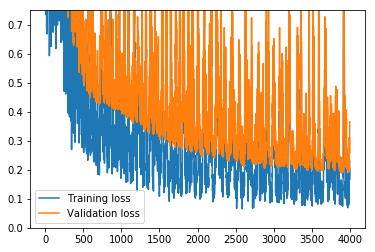

In [0]:
train_and_validate(model_v_2, optimizer_v_2, features_train_df, targets_train_df, features_validation_df, targets_validation_df, epochs, batch_size)

## Difference #2 Weight-Initialization and bias

After the above changes, my model's performance with the same hyperparameters was still much worser than the performance of the original numpy/pandas-based network. As pytorch adds a bias [1] to each linear layer to improve the network, I decided to remove this bias as the original network has no bias either. This can be done by a parameter for each layer:

`bias=False`

Additionally, I changed the weight initialization. Per default, pytorch initializes the weights of the model with a uniform distribution [1], and in the original network the weights are initialized via normal distribution [2]:

```
self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, (self.input_nodes, self.hidden_nodes))

self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5,  (self.hidden_nodes, self.output_nodes))
```

I initialize the weights for my model within the function `init_weights(m)`.

[1] https://pytorch.org/docs/stable/nn.html#linear

[2] https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-bikesharing/my_answers.py

## Model Version 3

In [0]:
class ModelVersion3(nn.Module):
  def __init__(self, input_nodes, hidden_nodes):
    super(ModelVersion3, self).__init__()
    self.fc_1 = nn.Linear(input_nodes, hidden_nodes, bias=False).double()
    self.fc_2 = nn.Linear(hidden_nodes, 1, bias=False).double()
 
  def forward(self, x):
    x = self.fc_1(x)
    x = torch.sigmoid(x)
    x = self.fc_2(x)
 
    return x

def init_weights(m):
  if type(m) == nn.Linear:
    m.weight.data.normal_(0, m.in_features ** -0.5)

model_v_3 = ModelVersion3(input_nodes, hidden_nodes)
model_v_3.apply(init_weights)

ModelVersion3(
  (fc_1): Linear(in_features=56, out_features=25, bias=False)
  (fc_2): Linear(in_features=25, out_features=1, bias=False)
)

## Train and validate model version 3

In [0]:
optimizer_v_3 = optim.SGD(model_v_3.parameters(), lr=learning_rate)

Progress: 101.0% Training loss: 0.827 Validation loss: 1.176 

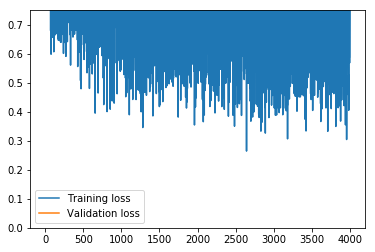

In [0]:
train_and_validate(model_v_3, optimizer_v_3, features_train_df, targets_train_df, features_validation_df, targets_validation_df, epochs, batch_size)

## Difference #3 Loss function
I am getting closer to the original performance. In the original network, the error for training the network is calculated by

`output - target`

and the loss for inference on the training and validation set is calculated by mean squared error.

Therefore I changed the loss function during training to mean absolute error.

Inference for training is done with full training set after training, I changed this, too.

## Train and validate - different loss function

In [0]:
model_v_3 = ModelVersion3(input_nodes, hidden_nodes)
model_v_3.apply(init_weights)

criterion_train = nn.L1Loss()
criterion_inference = nn.MSELoss()
optimizer = optim.SGD(model_v_3.parameters(), lr=learning_rate)

In [0]:
def train_and_validate_v2(model, optimizer, criterion_train, criterion_inference, features_train, targets_train, features_validation, targets_validation, epochs, batch_size):

  if train_on_gpu:
    model.cuda()

  train_losses, validation_losses = [], []
  for epoch in range(1, epochs+1):

    batch = np.random.choice(features_train.index, size=batch_size)
    X, y = features_train.iloc[batch].values, targets_train.iloc[batch]['cnt'].values
    
    features_batch = torch.tensor(X)
    targets_batch = torch.tensor(y)

    if train_on_gpu:
      features_batch, targets_batch = features_batch.cuda(), targets_batch.cuda()

    optimizer.zero_grad()
    output = model(features_batch)
    loss = criterion_train(output, targets_batch.unsqueeze(1))
    loss.backward()
    optimizer.step()

    # train inference and validate
    with torch.no_grad():
      model.eval()
      features_train_tensor = torch.tensor(features_train.values)
      targets_train_tensor = torch.tensor(targets_train['cnt'].values)
      features_valid_tensor = torch.tensor(features_validation.values)
      targets_valid_tensor = torch.tensor(targets_validation['cnt'].values)

      if train_on_gpu:
        features_train_tensor, targets_train_tensor = features_train_tensor.cuda(), targets_train_tensor.cuda()
        features_valid_tensor, targets_valid_tensor = features_valid_tensor.cuda(), targets_valid_tensor.cuda()

      output_train = model(features_train_tensor)
      output_validation = model(features_valid_tensor)
      loss_train = criterion_inference(output_train, targets_train_tensor.unsqueeze(1)).item()
      loss_validation = criterion_inference(output_validation, targets_valid_tensor.unsqueeze(1)).item()
    model.train()

    train_losses.append(loss_train)
    validation_losses.append(loss_validation)

    sys.stdout.write("\rProgress: {:2.1f}% Training loss: {:2.3f} Validation loss: {:2.3f} ".format(100*epoch/epochs+1, loss_train, loss_validation))
    sys.stdout.flush()
  plot(train_losses, validation_losses)

  return model

Progress: 101.0% Training loss: 0.064 Validation loss: 0.163 

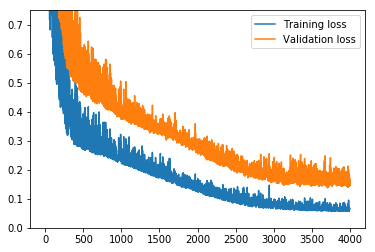

In [0]:
trained_model = train_and_validate_v2(model_v_3, optimizer, criterion_train, criterion_inference, features_train_df, targets_train_df,features_validation_df, targets_validation_df, epochs, batch_size)

## Test

In [0]:
def test(model_to_test, features, targets, targets_test_df):

  with torch.no_grad():
    model_to_test.eval()
    if train_on_gpu:
      features, targets = features.cuda(), targets.cuda()
      
    output = model_to_test(features)
    test_loss = criterion(output, targets)
    model_to_test.train()

    print("\nTest loss ", test_loss.item())

    fig, ax = plt.subplots(figsize=(8,4))
    mean, std = feature_scaling_store['cnt']
    ax.plot(output.cpu().numpy()*std + mean, label='Prediction')
    ax.plot((targets_test_df['cnt']*std + mean).values, label='Data')
    ax.set_xlim(right=len(output))
    ax.legend()
    dates = pd.to_datetime(rides_origin.iloc[test_data.index]['dteday'])
    dates = dates.apply(lambda d: d.strftime('%b %d'))
    ax.set_xticks(np.arange(len(dates))[12::24])
    _ = ax.set_xticklabels(dates[12::24], rotation=45)


Test loss  0.18393396161760406


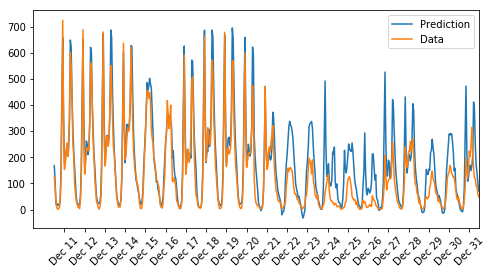

In [0]:
test(trained_model, torch.tensor(features_test_df.values), torch.tensor(targets_test_df.values), targets_test_df)

## Notes

##### .values on panda dataframe

During my investigation I made the error to use the dataframe `targets-train` directly as a series object. In one of my in-between-configurations, I could use this series as input for the loss-function and got results for the training/validation. But calculating directly on the Series-object instead of getting the values by the .values-method leads to calculation errors in my case.

##### losses are more oscilatting

In comparison to the original network, the training loss and validation loss are oscilatting in a greater range while they are dropping.
Maybe the reason could be that the original network backpropagates each input of the feature batch at a time while the pytorch model calculates it in a batch?